# Part 1. Traffic jams on a circular road

In [264]:
import numpy as np
import random

class TrafficSimulation:

    def __init__(self, length=100, car_density=0.2, slow_down_prob=0.5, max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.length = length
        self.car_density = car_density
        self.slow_down_prob = slow_down_prob
        self.max_speed = max_speed
        self.accum_flow = 0 # accumulative flow. We will get flow by accum_flow/steps
        self.steps = 0  # number of time steps the simulation has gone through
        self.state = np.array([-1]*length) # array of length sites. -1 means there's no car there
    
        # randomly choosing sites to have cars. Note that the number of cars in this road is fully determined
        # by int(car_density * length)
        indices = np.random.choice(range(length), size=int(car_density*length), replace=False)
        # for the sites chosen, randomly assigning speed (from 0 to max_speed)
        for ind in indices:
            self.state[ind] = np.random.randint(0, self.max_speed + 1)
        
        
#         self.next_state = list(self.current_state)


    def step(self, display=True):
        '''
        Advance one time step in the simulation.

        Inputs:

            display (bool) Whether to display the state of the simulation. Default: True.
        '''
        
        self.steps += 1 # update the number of time steps
        # update speed
        for i in range(self.length):
            
            ############################## START OF BLOCK ##################################
            ########### This block is to compute the distance of the current################
            ########### car and the next car. Distance is defined to be the ################
            ########### number of empty sites between these two cars plus 1 ################
            
            # skip the empty sites
            if self.state[i] == -1:
                continue
            # if the site has a car, compute distance between this car and the next car in 
            # the road
            distance = 0
            j = i
            while True:
                # if the car is not at the right most cell of the array, we will look at
                # the next cell
                if j < self.length - 1:
                    j += 1
                # if the car is at the right most cell, according to the boundary condition,
                # we look at the next cell which is the first cell (at index 0) of the array
                else:
                    j = 0
                # the distance is increased by 1
                distance += 1   
                if self.state[j] > -1:  
                    break
            ############################## END OF BLOCK ###################################   
            ############################################################################### 
            ############################################################################### 
            
            # rule 1, acceleration
            # if v is less than max speed, and if the distance to the next car is larger than v+1
            # accelerate
            if self.state[i] < self.max_speed and distance > self.state[i] + 1:
                self.state[i] += 1
            # rule 2, slowing down
            # if distance < v, decelerate, to avoid crashing
            if distance <= self.state[i]:
                self.state[i] = distance - 1
            # rule 3, randomization
            # decelerate  with probability slow_down_prob
            if random.random() < self.slow_down_prob:
                if self.state[i] > 0:
                    self.state[i] -= 1
        
        # this for loop counts the number of motion detected between the last and the first cell
        # of the road (the boundary). Here, we count the number of cars that exit 
        # the road on the right hand side and re-enter on the left hand side in each time step
        for i in range(1, self.max_speed+1):
            v = self.state[self.length-i] # current speed of the car, if any, at the right-most cell
            # if the speed is larger than the car's distance from the last cell, then it means when
            # the motion is implemented, the car will exit the road on the right hand side and re-
            # enter on the left. We update the acummulative flow
            if v>= i:
                self.accum_flow += 1
                
        if display:
            self.display()
            
        # rule 4, motion
        # after updating speeds for all cars (rule 4)
        new_state = np.array([-1]*self.length)
        for i in range(self.length):
            v = self.state[i]
            if v == -1: # skip empty sites
                continue
            new_state[int(i+v)%self.length] = v # advance by v sites
        self.state = new_state
    
        
    def get_flow(self):
        # compute the average flow 
        return self.accum_flow/self.steps
    
    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(int(x)) for x in self.state))
#         print(''.join(' ' if x == -1 else '.' for x in self.state))

## Visualize the state of model overtime with different car densities
The other settings are set to default (`length=100, slow_down_prob=0.5, max_speed=5`)

In [265]:
# write utility function to simulate with different densities
def runsim(display=True, num_steps=20,**kwargs):
    """
    display: boolean, display the states or not
    num_steps: int, how many updates
    """
    traffic = TrafficSimulation(**kwargs)
    for _ in range(num_steps):
        traffic.step(display)
    return traffic

In [266]:
density_list = [.05, .07, .1, .2, .4]
for car_density in density_list:
    print('\t\tCar density', car_density)
    runsim(car_density=car_density)
    print('\n\n')

		Car density 0.05
............................2................................1.0..2..............3..................
..............................3...............................01....2...............3...............
.................................3............................0.2.....3................3............
....................................3.........................1...2......3................4.........
.......................................4.......................2....2.......3.................5.....
...........................................4.....................2....3........3...................4
...5...........................................5...................3.....3........4.................
........4...........................................5.................4.....3.........5.............
............5............................................4................3....3...........4........
.................4...........................................4..........

## Represent overall average traffic flow rate varies with traffic density
The other settings are set to default (`length=100, slow_down_prob=0.5, max_speed=5`)

In [267]:
import matplotlib.pyplot as plt
# flows is a list of lists. Each element list corresponds to one density and contains 100 flows.
# therefore, in the plot,we will see that for each density point on the x-axis, there will be 
# multiple flows. 
flows_1_lane = []
densities_1_lane = []
for density in np.linspace(0,1,100):
    densities_1_lane.append(density)
    flows_1_lane.append([])
    for _ in range(100):
        sim = runsim(display=False, num_steps=100, car_density=density)
        flows_1_lane[-1].append(sim.get_flow())

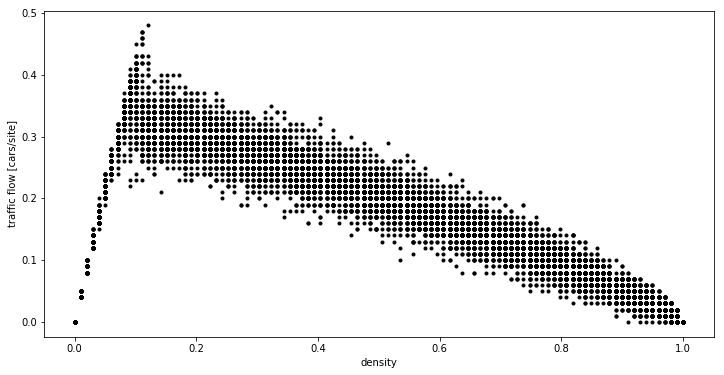

In [329]:
plt.figure(figsize=(12, 6))
plt.plot(densities_1_lane, flows_1_lane, 'k.')
plt.xlabel('density')
plt.ylabel('traffic flow [cars/site]')
plt.show()

### Deciding on the critical values by zooming in 


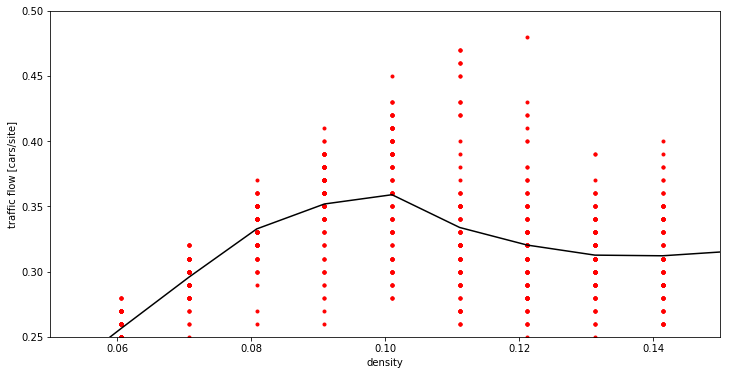

In [338]:
plt.figure(figsize=(12, 6))
plt.plot(densities_1_lane, flows_1_lane, 'r.')
mean_flow_1_lane = [np.mean(flow_lst) for flow_lst in flows_1_lane]
plt.plot(densities_1_lane, mean_flow_1_lane, 'k-')
plt.xlim(0.05, 0.15)
plt.ylim(0.25, 0.5)
plt.xlabel('density')
plt.ylabel('traffic flow [cars/site]')
plt.show()

In [372]:
# please ignore this cell. This is just to prepare some data for the plot at the end of this notebook
flows_1_lane_zoomed = []
densities_1_lane_zoomed = []
for density in np.linspace(.05,.15,50):
    densities_1_lane_zoomed.append(density)
    flows_1_lane_zoomed.append([])
    for _ in range(100):
        sim = runsim(display=False, num_steps=100, length=100, car_density=density)
        flows_1_lane_zoomed[-1].append(sim.get_flow())

## Traffic flow dependency on road length

In [271]:
## Traffic flow dependency on road length 400
flows_400 = []
densities_400 = []
for density in np.linspace(0,1,50):
    densities_400.append(density)
    flows_400.append([])
    for _ in range(30):
        sim = runsim(display=False, num_steps=100, length=400, car_density=density)
        flows_400[-1].append(sim.get_flow())

In [279]:
## Traffic flow dependency on road length 700
flows_700 = []
densities_700 = []
for density in np.linspace(0,1,50):
    densities_700.append(density)
    flows_700.append([])
    for _ in range(30):
        sim = runsim(display=False, num_steps=100, length=700, car_density=density)
        flows_700[-1].append(sim.get_flow())

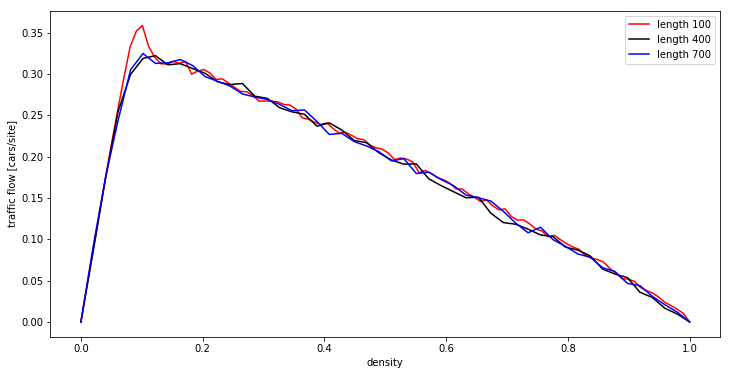

In [340]:
plt.figure(figsize=(12, 6))
mean_flow_400 = [np.mean(flow_lst) for flow_lst in flows_400]
mean_flow_700 = [np.mean(flow_lst) for flow_lst in flows_700]
plt.plot(densities_1_lane, mean_flow_1_lane, 'r-', label='length 100')
plt.plot(densities_400, mean_flow_400, 'k-', label='length 400')
plt.plot(densities_700, mean_flow_700, 'b-', label='length 700')
plt.xlabel('density')
plt.ylabel('traffic flow [cars/site]')
plt.legend()
plt.show()

# Part 2. Multi-lane highways

In [341]:
import numpy as np
import random
def get_gap(arr):
    """
    Given a 1D array (that represents one lane), computes and returns the 
    GAP between each car and the car ahead of it in its own lane.
    For example, 
    Input:  [-1, 0, 1, -1, -1, 2]
    Output: [-1, 0, 2, -1, -1, 1]
    """
    # convert arr into a numpy array
    arr = np.array(arr)
    length = len(arr)
    gap_arr = np.ones(length)*-1
    for i in range(length):
            
        ############################## START OF BLOCK ##################################
        ########### This block is to compute the distance of the current################
        ########### car and the next car. Distance is defined to be the ################
        ########### gap between these two cars plus 1                   ################

        # skip the empty sites
        if arr[i] == -1:
            continue
        # if the site has a car, compute distance between this car and the next car in 
        # the road
        distance = 0
        j = i
        while True:
            # if the car is not at the right most cell of the array, we will look at
            # the next cell
            if j < length - 1:
                j += 1
            # if the car is at the right most cell, according to the boundary condition,
            # we look at the next cell which is the first cell (at index 0) of the array
            else:
                j = 0
            # the distance is increased by 1
            distance += 1   
            if arr[j] > -1:  
                gap_arr[i] = distance - 1
                break
    return gap_arr 

def get_side_gap(arr, other):
    """
    Get gap between the car on this lane and the car ahead on the other lane
    For example
    Input [-1,1,-1,-1,2],
           [1,3,2,-1,-1]
    Output [-1,-1,-1,-1,0]
    """
    arr, other = np.array(arr), np.array(other)
    if len(arr) != len(other):
        raise ValueError('Two arrays must be of the same length')
    length = len(arr)
    gap_arr = np.ones(length)*-1
    for i in range(length):
        # skip the empty sites
        if arr[i] == -1:
            continue
        # if the site has a car, compute distance between this car and the next car in 
        # the the other lane
        distance = -1
        j = i-1
        while True:
            # if the previous cell that is considered is not at the right most cell of the array, 
            # we will look at the next cell
            if j < length - 1:
                j += 1
            # if the previous cell car that is considered is at the right most cell, according to the 
            # boundary condition, we look at the next cell which is the first cell (at index 0) of the array
            else:
                j = 0
            # the distance is increased by 1
            distance += 1
            if other[j] > -1:  
                gap_arr[i] = distance - 1
                break
    return gap_arr 
def get_back_side_gap(arr, other):
    """
    Get gap between the car on this lane and the car behind on the other lane
    For example
    Input [-1,1,-1,-1,2],
           [1,3,2,-1,-1]
    Output [-1,-1,-1,-1,1]
    """
    arr, other = np.array(arr), np.array(other)
    if len(arr) != len(other):
        raise ValueError('Two arrays must be of the same length')
    length = len(arr)
    gap_arr = np.ones(length)*-1
    for i in range(length):
        # skip the empty sites
        if arr[i] == -1:
            continue
        # if the site has a car, compute distance between this car and the next car in 
        # the the other lane
        distance = -1
        j = i+1
        while True:
            # if the previous cell that is considered is not at the left most cell of the array, 
            # we will look at the next previous cell
            if j > 0:
                j -= 1
            # if the previous cell car that is considered is at the left most cell, according to the 
            # boundary condition, we look at the last cell of the array
            else:
                j = length-1
            # the distance is increased by 1
            distance += 1
            if other[j] > -1:  
                gap_arr[i] = distance - 1
                break
    return gap_arr 

class MultiLaneTrafficSimulation(TrafficSimulation):

    def __init__(self, change_lane_args=None, num_lane=2, **kwargs):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:
            - change_lane_args (dict): key-values include:
                * el_0_back: l_0,back in condition T3 in the multilane paper, Default: max_speed 
                * p_change: p_change, in condition T4 in the multilane paper, Default: 1
            - num_lane (int) The number of lanes. Must be larger than 1.
            
            Keyword arguments include:
            
            - length (int) The number of cells in the road. Default: 100.

            - car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            - slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            - max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''

        TrafficSimulation.__init__(self, **kwargs)
        if not change_lane_args:
            self.change_lane_args = {'el_0_back': self.max_speed, 
                                'p_change': 1}
        else:
            self.change_lane_args = change_lane_args
        self.num_lane = num_lane
        # create an array of length num_lane*length (the total number of cells across the lanes).
        # Later we will reshape this 1D array into a 2D array where each row is a lane, 
        # and the length of each row is the length of road
        # -1 means there's no car there
        self.state = np.ones(self.num_lane * self.length)*-1 
        
        # randomly choosing sites to have cars. Note that the number of cars in this road is fully determined
        # by int(car_density * length * num_lane)
        indices = np.random.choice(range(self.length*self.num_lane), 
                                   size=int(self.car_density*self.length*self.num_lane), 
                                   replace=False)
        # for the sites chosen, randomly assigning speed (from 0 to max_speed)
        for ind in indices:
            self.state[ind] = np.random.randint(0, self.max_speed + 1)
        # reshape the state into 2D array
        self.state = self.state.reshape((self.num_lane, self.length))

    def step(self, display=True):
        '''
        Advance one time step in the simulation.

        Inputs:

            display (bool) Whether to display the state of the simulation. Default: True.
        '''
        ########################################################################################
        #################################### START OF BLOCK 1 ##################################
        ########### This block performs the first half of the update step ######################
        ########### I.e., the lane switching update ############################################
        ########### The other half is the speed update #########################################
        ########### The output of this step is stored in lane_switch results ###################
        
        self.steps += 1 # update the number of time steps
        # update lane switching
        lane_switch_results = np.ones((self.num_lane, self.length)) *-1
        for i in range(self.num_lane): # loop over each lane
            this_lane = self.state[i,:] # get the row of this lane
            
            # this list contains indices of other lanes that we need to consider for the update rules
            # the first two indices are for two lanes that are immediately beside this lane
            # the last two indices are for two lanes that are one lane away from this lane
            # For example, if there are 5 lanes, and this_lane is the middle lane (index 2), then
            # other_lanes_indices = [1,3,0,4]
            # If any index is out of range, it will be converted to None
            # For example, if there are 5 lanes, and this_lane is the first lane (index 0), then
            # other_lanes_indices = [None, 1, None, 2]
            other_lanes_indices = []
            for offset in [-1, +1, -2, +2]:
                if i+offset >= 0 and i+offset < self.num_lane:
                    other_lanes_indices.append(i+offset)
                else:
                    other_lanes_indices.append(None)
                    
            other_lanes = [] # list contains 4 lanes
            for ind in other_lanes_indices:
                if not ind is None:
                    other_lanes.append(self.state[ind,:])
                else:
                    other_lanes.append(None)
            own_gap = get_gap(this_lane)
            gap_ahead_on_other_lane1 = get_side_gap(this_lane, other_lanes[0]) if not other_lanes[0] is None else None
            gap_ahead_on_other_lane2 = get_side_gap(this_lane, other_lanes[1]) if not other_lanes[1] is None else None
            gap_back_on_other_lane1 = get_back_side_gap(this_lane, other_lanes[0]) if not other_lanes[0] is None else None
            gap_back_on_other_lane2 = get_back_side_gap(this_lane, other_lanes[1]) if not other_lanes[1] is None else None
            gap_back_on_other_lane3 = get_back_side_gap(this_lane, other_lanes[2]) if not other_lanes[2] is None else None
            gap_back_on_other_lane4 = get_back_side_gap(this_lane, other_lanes[3]) if not other_lanes[3] is None else None
            
            for j in range(self.length):
                if this_lane[j] == -1:  # skip empty sites
                    continue 
                # condition 1: gap(i) < el (condition 1 in the paper)
                cond1 = own_gap[j] < this_lane[j] + 1
                # condition 2: gap_0(i) > el_0 (condition 2 in the paper)
                cond2_lane1 = gap_ahead_on_other_lane1[j] > this_lane[j] + 1 if not gap_ahead_on_other_lane1 is None else False
                cond2_lane2 = gap_ahead_on_other_lane2[j] > this_lane[j] + 1 if not gap_ahead_on_other_lane2 is None else False
                # condition 3: gap_0,back(i) > el_0,back (condition 3 in the paper)
                cond3_lane1 = gap_back_on_other_lane1[j] > self.change_lane_args['el_0_back'] if not gap_back_on_other_lane1 is None else False
                cond3_lane2 = gap_back_on_other_lane2[j] > self.change_lane_args['el_0_back'] if not gap_back_on_other_lane2 is None else False
                # condition 4: rand() < p_change ((condition 4 in the paper))
                cond4_lane1 = random.random() < self.change_lane_args['p_change']
                cond4_lane2 = random.random() < self.change_lane_args['p_change']
                # condition 5: 
                if gap_back_on_other_lane3 is None: # there is no lane that is 1 lane from the current lane,
                                                    # so we are free to change lane if we want to
                    cond5_lane1 = True
                else:
                    cond5_lane1 = gap_back_on_other_lane3[j] > self.change_lane_args['el_0_back']
                    
                if gap_back_on_other_lane4 is None: # there is no lane that is 1 lane from the current lane,
                                                    # so we are free to change lane if we want to
                    cond5_lane2 = True
                else:
                    cond5_lane2 = gap_back_on_other_lane4[j] > self.change_lane_args['el_0_back']
                
                
                is_change_to_lane_1 = cond1 and cond2_lane1 and cond3_lane1 and cond4_lane1 and cond5_lane1
                is_change_to_lane_2 = cond1 and cond2_lane2 and cond3_lane2 and cond4_lane2 and cond5_lane2
                
                lane_to_change_to = 0
                if is_change_to_lane_1 and is_change_to_lane_2: 
                    # if potentially change to both lanes, randomly pick one lane
                    lane_to_change_to = random.choice([-1,+1])
                elif is_change_to_lane_1:
                    lane_to_change_to = -1
                elif is_change_to_lane_2:
                    lane_to_change_to = +1
                lane_switch_results[i+lane_to_change_to, j] = this_lane[j]
          # run the following three lines if want to inspect the results of the first half of the update step  
#         print('lane switch results:')    
#         for i in range(self.num_lane):
#             print(''.join('.' if x == -1 else str(int(x)) for x in lane_switch_results[i,:]))
        #################################### END OF BLOCK 1 ####################################
        ########################################################################################
        
        
        
        ########################################################################################
        #################################### START OF BLOCK 2 ##################################
        ########### This block performs the second half of the update step #####################
        ########### I.e., the speed update #####################################################
        ########### The output of this step is stored in new_state #############################
        new_state = np.ones((self.num_lane, self.length)) *-1
        for i in range(self.num_lane): # loop over each lane
            lane = lane_switch_results[i,:]
            gap_lst = get_gap(lane)
            distance = [] # distance is defined to be gap + 1, so the for loop below reflects this
                          # It skips empty sites and maintain those sites to be -1
            for gap in gap_lst:
                if gap > -1:
                    distance.append(gap+1) 
                else: # skip empty sites
                    distance.append(gap)
            
            for j in range(self.length):
                # skip the empty sites
                if lane[j] == -1:
                    continue
                # rule 1, acceleration
                # if v is less than max speed, and if the distance to the next car is larger than v+1
                # accelerate
                if lane[j] < self.max_speed and distance[j] > lane[j] + 1:
                    lane[j] += 1
                # rule 2, slowing down
                # if distance < v, decelerate, to avoid crashing
                if distance[j] <= lane[j]:
                    lane[j] = distance[j] - 1
                # rule 3, randomization
                # decelerate  with probability slow_down_prob
                if random.random() < self.slow_down_prob:
                    if lane[j] > 0:
                        lane[j] -= 1
            lane_switch_results[i,:] = lane
        
        
        
        self.state = lane_switch_results

        ##################################################
        ############# START OF SUBBLOCK ##################
        ######## This subblock is to compute and #########
        ######## update the accumulative flow ############
        for i in range(self.num_lane): # loop over each lane
            lane = self.state[i,:]
            # this for loop counts the number of motion detected between the last and the first cell
            # of the lane (the boundary). Here, we count the number of cars that exit 
            # the lane on the right hand side and re-enter on the left hand side in each time step
            for i in range(1, self.max_speed+1):
                v = lane[self.length-i] # current speed of the car, if any, at the right-most cell
                # if the speed is larger than the car's distance from the last cell, then it means when
                # the motion is implemented, the car will exit the road on the right hand side and re-
                # enter on the left. We update the acummulative flow
                if v>= i:
                    self.accum_flow += 1
        ############# END OF SUBBLOCK ####################
        ##################################################
        
        if display:
            self.display()
        
        # motion (rule 4)
        for i in range(self.num_lane): # loop over each lane
            for j in range(self.length): # loop over each site in the lane
                v = lane_switch_results[i,j]
                if v == -1: 
                    continue # skip empty sites
                else:
                    new_state[i, int(j+v)%self.length] = v # move
        self.state = new_state
        
        #################################### END OF BLOCK 2 ####################################
        ########################################################################################
    
    def get_flow(self):
        # compute the average flow 
        return self.accum_flow/(self.steps*self.num_lane)
    
    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        
        for i in range(self.num_lane):
            print(''.join('.' if x == -1 else str(int(x)) for x in self.state[i,:]))

In [342]:
# sanity check: code for visual inspection
traffic = MultiLaneTrafficSimulation(length=20)
for i in range(5):
    print('Iteration', i)
    traffic.step()

Iteration 0
.1.1...0.0.....1.2..
....4.........1.....
Iteration 1
....2..1.1......2..3
..1.....4......1....
Iteration 2
..2...0.1.1.......2.
...1........3...2...
Iteration 3
2...1.1..1.1........
....1..........1..3.
Iteration 4
..2..0.2..0.2.......
.3...1..........1...


In [348]:
# sanity check: code for visual inspection, num lane = 3
traffic = MultiLaneTrafficSimulation(num_lane=3, length=20)
for i in range(5):
    print('Iteration', i)
    traffic.step()

Iteration 0
.2..01.........1.2..
...3....0.1..1..1...
..1....5............
Iteration 1
...00.1.........2..2
......0.1..1..2..2..
...1........4.......
Iteration 2
.0.01..2..........1.
......0..1..1...2..3
....1...........4...
Iteration 3
.1.1.2...2.........0
..2...0...2..2....2.
3....2..............
Iteration 4
..1.1..3...2.......1
2...1.0.....2..3....
...3...3............


## Visualize the state of this model over time, to show the typical traffic patterns that can emerge. Your results will again depend on traffic density.

In [345]:
# function to display two lanes side by side
def display_two_lanes(state):
    """
    state (numpy 2d array) what is returned by the state attribute of the traffic model
    """
    lane1 = state[0,:]
    lane2 = state[1,:]
    lane1_str = ''.join('.' if x == -1 else str(int(x)) for x in lane1)
    lane2_str = ''.join('.' if x == -1 else str(int(x)) for x in lane2)
    print(lane1_str,'     ', lane2_str)
    

### Density = 0.05

In [355]:
print('\t\t\t\t\t      Density = 0.05')
traffic = MultiLaneTrafficSimulation(num_lane=2, length=50, car_density=.05)
for _ in range(20):
    traffic.step(display=False)
    display_two_lanes(traffic.state)

					      Density = 0.05
........................3.......2.......1.........       ........................................4......0..
...........................3.......3.....1........       .............................................5..1.
...............................4.......4...2......       ...............................................2.1
...................................4..........3...       1..........................................4....1.
4.......................................5.........       ..2............................................40.
....4........................................5....       .....3.........................................0.1
5.......4.........................................       .2.......4......................................1.
....4........5....................................       2...3.........5...................................
.........5........5...............................       ...3...3..........4...............................
..

### Density = 0.1

In [359]:
print('\t\t\t\t\t      Density = 0.1')
traffic = MultiLaneTrafficSimulation(num_lane=2, length=50, car_density=.1)
for _ in range(20):
    traffic.step(display=False)
    display_two_lanes(traffic.state)

					      Density = 0.1
...4.................3.........2.1...2..........0.       .....2...3.........4.............1................
.......4................3......0...2....3.......0.       ........3....4.........4..........1...............
............5...............4..0.....2.....3....0.       ............4....4..........5.......2.............
.................5...........1..1......2......3.0.       ...............3.....4..........4.....2...........
......................5........2.1.......2.......1       4.................3......4..........4...2.........
.2........................4.....1.1........2......       .....5...............3........5.......2....3......
...2...........................5.1..2.........3...       .........4..............3..........5.....3.....4..
.....2..........................1.1....3.........3       ..5...........5.............4..........4....3.....
...4....3........................1..2.....3.......       .......5...........5............4..........4...3..
...

### Density = 0.2

In [361]:
print('\t\t\t\t\t      Density = 0.2')
traffic = MultiLaneTrafficSimulation(num_lane=2, length=50, car_density=.2)
for _ in range(20):
    traffic.step(display=False)
    display_two_lanes(traffic.state)

					      Density = 0.2
..3.0........2......4..00...30.00...3.............       .5....3.......20.0....4......1...1.....5..........
..0..1..........3....1.00...0.10.1.....3..........       .....4....4...00..1........5...2...2.......4......
..0...1............3..10.1...10.1..2......3.......       .........4..2.0.1...2.........3...3...3.........5.
..0.....2............200...2.0.1..2...3......3....       ...5......1..10..1.....3.........3...3...3........
..0.......2..........000...0.0..1...2.....4......4       ........5..1.00....2.......4.......2....3...3.....
1..1........2........00.1...10....2....3.......5..       ..........20.0.1......3.........5.....3...2....3..
.1...2.........3.....00..1..00......2......4....1.       .4........00.0...2.......3...........5...3...3....
..1....2...........4.0.1...200........2........4.1       .....4....0.1.1....2.........4..........3..2.....4
1...2....2..........10..1..000...........3......1.       ...4.....40..1..2.....3...........5......1....3...
..2

### Density = 0.4

In [362]:
print('\t\t\t\t\t      Density = 0.4')
traffic = MultiLaneTrafficSimulation(num_lane=2, length=50, car_density=.4)
for _ in range(20):
    traffic.step(display=False)
    display_two_lanes(traffic.state)

					      Density = 0.4
0.0...3..2.1.......3..0.1....3.1..2.....4...2..2.0       ..2.0.0..2..000...3.000.1.00.1.00.1.00.1.10..2..2.
0..1...1..1..2......1..1.1....1.1...2.....2..1.0.0       .3.1.10...1.00.1..0.00.10.00.0.00.0.00.0.00....2..
.1..1....2.1....3....1.0..1....1..2....3....2.10.0       30.0.00....100..1..10.100.0.10.00.0.0.1.100.......
1.1...2...1.1.......4.10....2....2...3....3.0.00..       0.10.0.1...00.1...200.00.10.0.10.10.0..100.1......
0...2....30...2......10.1......3....3...3.0.0.0.1.       .100.0...2.0.1.1..000.00.00..100.00..1.000...2....
.1....2..00......3...0.1.1........3...2.0..10.0..1       .00.1.1..0..1.1..2000.00.00..000.00...1000.....2..
..1....1.0.1.......2.0..1.1..........3.1.1.00.0..0       300..1.1.0..0..1.000.10.100..00.10.1..000.1.......
1..1....10..1......0.0..0..1..........10..100.0...       000..0..1.1..1..1000.00.000..0.10.1.1.00.1.1......
.1...2..0.1...2.....1.1.0...1......1..00..000..1..       000..0...1.1...20000.0.100.1..100....100.0..1.....
...

## Analyze how much more traffic can flow through a multi-lane road, compare to a single lane road, at the same traffic density. 

In [363]:
# write utility function to simulate with different densities
def runsim_multilane(display=True, num_lane=1, num_steps=20,**kwargs):
    """
    display: boolean, display the states or not
    num_steps: int, how many updates
    """
    traffic = MultiLaneTrafficSimulation(num_lane=num_lane, **kwargs)
    for _ in range(num_steps):
        traffic.step(display)
    return traffic

In [364]:
def get_flow_data(num_lane):
    flows = []
    densities = []
    for density in np.linspace(.05,.15,50):
        densities.append(density)
        flows.append([])
        for _ in range(30):
            sim = runsim_multilane(display=False, num_lane=num_lane, num_steps=100, car_density=density)
            flows[-1].append(sim.get_flow())
    return densities, flows



In [322]:
densities_2_lane, flows_2_lane_data = get_flow_data(2)

In [319]:
densities_3_lane, flows_3_lane_data = get_flow_data(3)

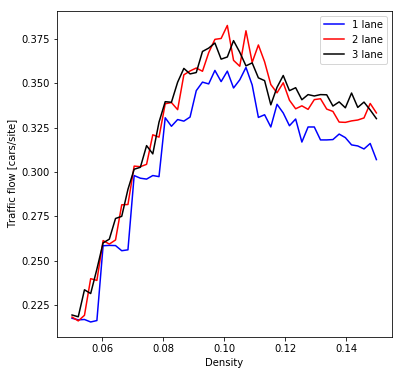

In [373]:
mean_flows_2_lane = [np.mean(flow_lst) for flow_lst in flows_2_lane_data]
mean_flows_3_lane = [np.mean(flow_lst) for flow_lst in flows_3_lane_data]
mean_flows_1_lane_zoomed = [np.mean(flow_lst) for flow_lst in flows_1_lane_zoomed]


plt.figure(figsize=(6, 6))
plt.plot(densities_1_lane_zoomed, mean_flows_1_lane_zoomed,'b-', label='1 lane')
plt.plot(densities_2_lane, mean_flows_2_lane,'r-', label='2 lane')
plt.plot(densities_3_lane, mean_flows_3_lane,'k-', label='3 lane')
plt.xlabel('Density')
plt.ylabel('Traffic flow [cars/site]')
plt.legend()
plt.show()

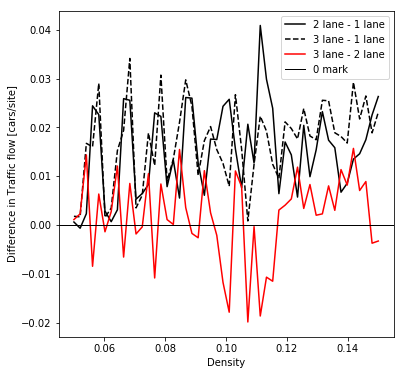

In [385]:
import matplotlib
lane_21 = np.array(mean_flows_2_lane) - np.array(mean_flows_1_lane_zoomed)
lane_31 = np.array(mean_flows_3_lane) - np.array(mean_flows_1_lane_zoomed)
lane_32 = np.array(mean_flows_3_lane) -np.array(mean_flows_2_lane)
plt.figure(figsize=(6, 6))
plt.plot(densities_1_lane_zoomed, lane_21,'k-', label='2 lane - 1 lane')
plt.plot(densities_2_lane, lane_31,'k--', label='3 lane - 1 lane')
plt.plot(densities_3_lane, lane_32,'r-', label='3 lane - 2 lane')
plt.axhline(linewidth=1, color='k', label='0 mark')
plt.xlabel('Density')
plt.ylabel('Difference in Traffic flow [cars/site]')
plt.legend()
plt.show()